In [12]:
using Base.Iterators: partition
using BSON
using Flux
using Flux: logitbinarycrossentropy, chunk
using Flux.Data: DataLoader
using Images
using Parameters: @with_kw
using Random
using CUDA
using JSON
using Plots
using DrWatson: struct2dict

device = gpu

const n_patients   = 5366
const DS_PATH      = "../dataset_json/"

"../dataset_json/"

In [13]:
# return list of patients with their trajectories
function load_patients()
    patients = []
    for i = 1:n_patients
        p = JSON.parsefile(DS_PATH * "patient_" * string(i) * ".json")
        push!(patients, p) 
    end
    return patients
end

load_patients (generic function with 1 method)

In [14]:
patients = load_patients();

In [15]:
function feature_vector(p)
    S, MAP, mortality = p["trajectory"], p["MAP"], p["mortality"]
    function trs(i)
        i = max(1, i)
        return convert(Array{Float32}, [S[i]; MAP[i] / 209])
    end
    return [vcat(trs(i - 3), trs(i - 2), trs(i - 1), trs(i)) for i=1:length(S)]
end

function target_vector(p)
    S, MAP, mortality = p["trajectory"], p["MAP"], p["mortality"]
    return [MAP[i] * (mortality ? -1 : 1) for i=1:length(S)]
end

target_vector (generic function with 1 method)

In [16]:

# load MNIST images and return loader
function get_data(batch_size, ps)
    p_m     = length(ps)
    m       = 0
    x_train = []
    y_train = []
    for i=1:p_m
        pd = hcat(feature_vector(ps[i])...)
        push!(x_train, pd)
        m += size(pd)[2]
        push!(y_train, vcat(target_vector(ps[i])...))
         
    end
    x_train = hcat(x_train...)
    y_train = vcat(y_train...)
    
    println(size(x_train))
    println(size(y_train))
    
    DataLoader(x_train, y_train, batchsize = batch_size, shuffle = true)
end

get_data (generic function with 1 method)

In [17]:
loader = get_data(512, patients);

(200, 352328)
(352328,)


In [18]:
struct Encoder
    hidden
    enc
    function Encoder(input_dim, latent_dim, hidden_dims, device) 
        prev   = input_dim
        hidden = []
        for hdim in hidden_dims
            push!(hidden, Dense(prev, hdim, Flux.relu))
            prev = hdim
        end
        h = Chain(hidden...) |> device
        enc = Dense(prev, latent_dim) |> device
        return new(h, enc)
    end
end

In [19]:
function (encoder::Encoder)(x)
    h = encoder.hidden(x)
    encoder.enc(h)
end

function Decoder(input_dim, latent_dim, hidden_dims, device)
    prev   = latent_dim
    layers = []
    for hdim in reverse(hidden_dims)
        push!(layers, Dense(prev, hdim, Flux.relu))
        prev = hdim
    end
    push!(layers, Dense(prev, input_dim))
    chain = Chain(layers...) |> device
    return chain
end

Decoder (generic function with 1 method)

In [20]:

function model_loss(encoder, decoder, λ, x, device)
    h, decoded = reconstuct(encoder, decoder, x, device)
    len = size(x)[end]
    
    mse_loss = sum(Flux.Losses.mse.(decoded, x)) / len
    reg      = λ * sum(x->sum(x.^2), Flux.params(decoder))
    
    return mse_loss + reg
end

model_loss (generic function with 1 method)

In [99]:
# arguments for the `train` function 
@with_kw mutable struct Args
    η = 1e-5                # learning rate
    λ = 0.2f0               # regularization paramater
    batch_size = 512        # batch size
    sample_size = 10        # sampling size for output    
    epochs = 20             # number of epochs
    seed = 0                # random seed
    cuda = true             # use GPU
    input_dim = 200         # feature vector size
    latent_dim = 3          # latent dimension
    hidden_dim = [200, 100, 50] # hidden dimensions
    verbose_freq = 1000     # logging for every verbose_freq iterations
    tblogger = false        # log training with tensorboard
    save_path = "output"    # results path
end

Args

In [100]:
args = Args()

Args
  η: Float64 1.0e-5
  λ: Float32 0.2f0
  batch_size: Int64 512
  sample_size: Int64 10
  epochs: Int64 20
  seed: Int64 0
  cuda: Bool true
  input_dim: Int64 200
  latent_dim: Int64 3
  hidden_dim: Array{Int64}((3,)) [200, 100, 50]
  verbose_freq: Int64 1000
  tblogger: Bool false
  save_path: String "output"


In [114]:
println("Initializing VAE model...")
encoder = Encoder(args.input_dim, args.latent_dim, args.hidden_dim, device)
decoder = Decoder(args.input_dim, args.latent_dim, args.hidden_dim, device)

# opt = RMSProp(0.00005)
# opt = RADAM(0.00005)    
# opt = AdaMax(0.00001)

# parameters
ps = Flux.params(encoder.hidden, encoder.enc, decoder)

Initializing VAE model...


Params([Float32[0.006739054 -0.120767586 … -0.06424974 -0.028478714; -0.012232691 0.052636035 … 0.058779053 -0.022757754; … ; -0.058783375 -0.085790426 … -0.015687073 -0.08331995; -0.022959149 -0.049872324 … 0.025735298 -0.07818188], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.12879395 0.13658515 … -0.036795814 0.023542386; 0.011021805 -0.0920475 … 0.07741863 -0.13912037; … ; -0.021469569 0.06017875 … -0.011552787 -0.09982501; 0.096803114 0.13407792 … -0.08706466 0.10603624], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.116871454 -0.16702667 … -0.075792454 -0.04477606; -0.044459965 0.18420254 … 0.19254194 0.18011728; … ; 0.14539532 -0.0843328 … 0.093148135 -0.05628257; -0.14251442 0.07795725 … 0.15386663 -0.17445122], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Floa

In [115]:
!ispath(args.save_path) && mkpath(args.save_path)

false

In [116]:
function reconstuct(encoder, decoder, x, device)
    h = encoder(x)
    return h, decoder(h)
end

reconstuct (generic function with 1 method)

In [117]:
train_steps  = 0
train_losses = []
for epoch = 1:args.epochs
    print("\nEpoch $(epoch)")
    loss = 0.0

    for (x, _) in loader 
        loss, back = Flux.pullback(ps) do
            model_loss(encoder, decoder, args.λ, x |> device, device)
        end
        
        grad = back(1f0)
        Flux.Optimise.update!(opt, ps, grad)

        if train_steps % 25 == 1
            print(".")
            push!(train_losses, loss)
        end

        train_steps += 1
    end
    
    println("loss:", loss)
end


Epoch 1............................loss:91.78819

Epoch 2............................loss:65.13124

Epoch 3...........................loss:43.4392

Epoch 4............................loss:34.86339

Epoch 5...........................loss:28.241844

Epoch 6............................loss:24.980455

Epoch 7...........................loss:24.567131

Epoch 8............................loss:23.687569

Epoch 9...........................loss:23.67106

Epoch 10............................loss:23.93082

Epoch 11............................loss:21.11206

Epoch 12...........................loss:21.536436

Epoch 13............................loss:21.61611

Epoch 14...........................loss:22.034702

Epoch 15............................loss:21.056284

Epoch 16...........................loss:19.277088

Epoch 17............................loss:21.665453

Epoch 18............................loss:21.9615

Epoch 19...........................loss:23.16647

Epoch 20............................loss

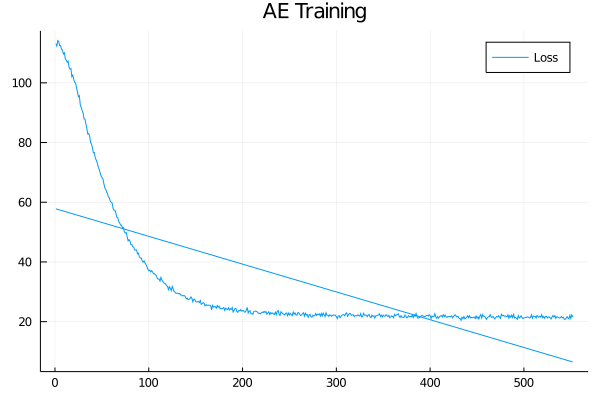

In [118]:
plot(1:length(train_losses), train_losses, title = "AE Training", label = "Loss", smooth = true)

In [120]:
state =  feature_vector(patients[1])[1] |> device
reconstuct(encoder, decoder, state, device)[2]

200-element CuArray{Float32,1}:
 -0.010478525
  0.119872004
 -0.13462004
 -0.2794974
 -0.27296406
 -0.19000185
 -0.20798936
 -0.120045274
  0.007638855
  0.19020067
  0.14385201
 -0.015354017
  0.001166733
  ⋮
  0.13285121
 -0.25390297
  0.18239045
  0.18515363
  0.19258745
 -0.14991339
 -0.15109846
 -0.15102205
 -0.04398597
 -0.049848378
 -0.0480417
  0.3067612

In [121]:
feature_vector(patients[1])[1]

200-element Array{Float32,1}:
 -0.35948172
  0.43990737
 -1.0590913
 -0.48791927
 -0.1743005
 -0.14888796
 -0.13654973
 -0.61029875
 -0.24194391
  0.28084475
  0.15390423
 -0.06261549
 -0.1839509
  ⋮
  0.22211784
 -0.108395904
  0.28033373
  0.2831705
  0.2850545
  0.34823036
  0.34936163
  0.35055524
 -0.5739797
 -0.56734794
 -0.56106305
  0.39712918

In [122]:
# save model
model_path = joinpath(args.save_path, "model.bson") 
let encoder = cpu(encoder), decoder = cpu(decoder), args=struct2dict(args)
    BSON.@save model_path encoder decoder args
    @info "Model saved: $(model_path)"
end

┌ Info: Model saved: output/model.bson
└ @ Main In[122]:5


In [123]:
function plot_result(loader, centers = nothing)
    
    BSON.@load "output/model.bson" encoder decoder args
    
    device = args[:cuda] ? gpu : cpu
    encoder, decoder = encoder |> device, decoder |> device
    
    #
    # clustering in the latent space
    # visualize first two dims
    #
    plt = scatter3d(palette=:rainbow)
    
    function get_color(y)
        if y < 0
            v = abs(y)
            if v > 65
                return :blue
            else
                return :red
            end    
        else
            if y > 65
                return :green
            else
                return :yellow
            end
        end
    end
    
    for (i, (x, y)) in enumerate(loader)
        
        i < 10 || break
        
        h = encoder(x |> device) |> cpu
        
        colors = [get_color(v) for v in y]
        
        scatter3d!(h[1, :], h[2, :], h[3, :], 
            markerstrokewidth = 0, 
            markeralpha = 0.5,
            markersize = 2,
            aspect_ratio = 1,
            markercolor = colors, 
            label = "")
    end
    
    if !isnothing(centers)
        scatter3d!(centers[1, :], centers[2, :], centers[3, :],
            markerstrokewidth = 1, 
            markersize = 3,
            aspect_ratio = 1,
            stroke = :black,
            markercolor = :white, 
            label = "")
    end
    
    savefig(plt, "output/clustering.png")
    display(plt)
    
end

plot_result (generic function with 2 methods)

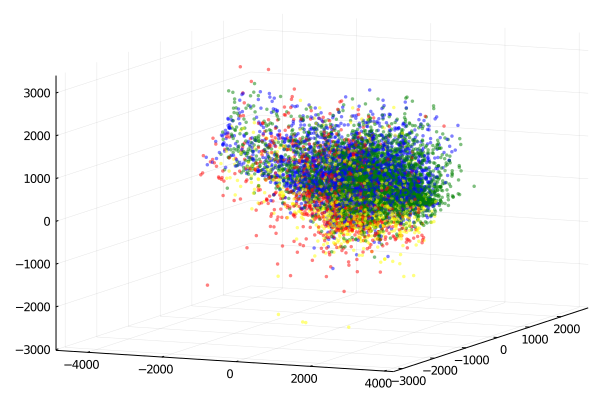

In [124]:
plot_result(loader)

In [125]:
args

Args
  η: Float64 1.0e-5
  λ: Float32 0.2f0
  batch_size: Int64 512
  sample_size: Int64 10
  epochs: Int64 20
  seed: Int64 0
  cuda: Bool true
  input_dim: Int64 200
  latent_dim: Int64 3
  hidden_dim: Array{Int64}((3,)) [200, 100, 50]
  verbose_freq: Int64 1000
  tblogger: Bool false
  save_path: String "output"


In [126]:
include("../state_cluster/state_utils.jl")

load_patients (generic function with 1 method)

In [127]:
states2d = []
for (i, (x, y)) in enumerate(loader)
    h = encoder(x |> device)
    push!(states2d, h)
end
S₂ = hcat(states2d...) |> cpu

3×352328 Array{Float32,2}:
 1864.08    1400.24   -448.54   -822.303  …  -544.128  1117.82     383.887
   71.8358  -555.663  -368.409   836.511     -238.363  1117.38   -1200.46
  676.341   1367.03    248.794   403.661      207.008   446.032   1636.56

In [128]:
clusters = k_means_pp(S₂[:,1:50000], n_states);

k_means_pp 1 of 750
k_means_pp 11 of 750
k_means_pp 21 of 750
k_means_pp 31 of 750
k_means_pp 41 of 750
k_means_pp 51 of 750
k_means_pp 61 of 750
k_means_pp 71 of 750
k_means_pp 81 of 750
k_means_pp 91 of 750
k_means_pp 101 of 750
k_means_pp 111 of 750
k_means_pp 121 of 750
k_means_pp 131 of 750
k_means_pp 141 of 750
k_means_pp 151 of 750
k_means_pp 161 of 750
k_means_pp 171 of 750
k_means_pp 181 of 750
k_means_pp 191 of 750
k_means_pp 201 of 750
k_means_pp 211 of 750
k_means_pp 221 of 750
k_means_pp 231 of 750
k_means_pp 241 of 750
k_means_pp 251 of 750
k_means_pp 261 of 750
k_means_pp 271 of 750
k_means_pp 281 of 750
k_means_pp 291 of 750
k_means_pp 301 of 750
k_means_pp 311 of 750
k_means_pp 321 of 750
k_means_pp 331 of 750
k_means_pp 341 of 750
k_means_pp 351 of 750
k_means_pp 361 of 750
k_means_pp 371 of 750
k_means_pp 381 of 750
k_means_pp 391 of 750
k_means_pp 401 of 750
k_means_pp 411 of 750
k_means_pp 421 of 750
k_means_pp 431 of 750
k_means_pp 441 of 750
k_means_pp 451 of 750

In [129]:
# now we call standard k-means
m_centroids = hcat(clusters...)
R           = kmeans!(S₂, m_centroids)

KmeansResult{Array{Float32,2},Float32,Int64}(Float32[532.4529 -3937.296 … 448.0218 876.9025; -246.95049 604.1897 … 45.291645 778.4395; 731.39136 1009.8073 … 748.5301 177.46146], [420, 680, 265, 434, 706, 382, 590, 379, 691, 681  …  656, 656, 382, 179, 362, 60, 610, 265, 149, 354], Float32[22953.0, 45102.0, 6768.8125, 34039.0, 4792.5, 30740.25, 61876.0, 36468.5, 20395.125, 25656.5  …  15424.1875, 15938.75, 64541.0, 21125.594, 29545.0, 7577.75, 39561.0, 18602.375, 27242.5, 102838.0], [1218, 36, 47, 116, 12, 39, 6, 58, 88, 362  …  362, 175, 1047, 596, 262, 313, 129, 1406, 893, 1230], [1216, 36, 47, 116, 12, 39, 6, 58, 88, 362  …  362, 175, 1049, 595, 261, 313, 129, 1400, 896, 1235], 1.1241011f10, 100, false)

In [130]:
centers = R.centers

3×750 Array{Float32,2}:
  532.453  -3937.3   -1560.18    -291.737  …   -9.57506  448.022   876.903
 -246.95     604.19    439.763  -3042.49       24.3998    45.2916  778.44
  731.391   1009.81  -2573.65    3176.91      180.147    748.53    177.461

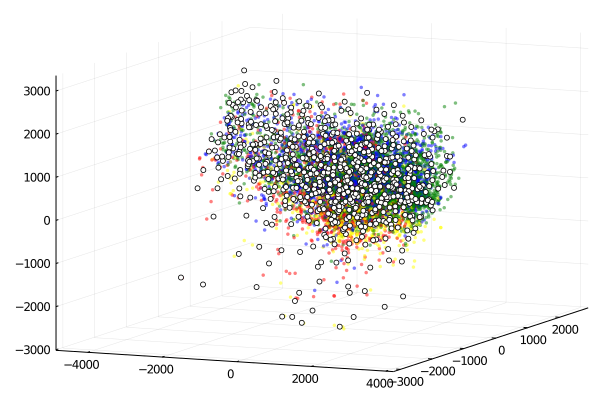

In [131]:
plot_result(loader, centers)

In [138]:
state_vectors_file = apath * "state_vectors_vae2.json" 
save_state_vectors(state_vectors_file, centers)

In [139]:
lvc = restore_state_vectors(state_vectors_file)

3×750 Array{Float64,2}:
  532.453  -3937.3   -1560.18    -291.737  …   -9.57506  448.022   876.903
 -246.95     604.19    439.763  -3042.49       24.3998    45.2916  778.439
  731.391   1009.81  -2573.65    3176.91      180.147    748.53    177.461

In [140]:
# after save-restore matrices should be the almost the same
centers ≈ lvc

true

In [141]:
function get_vae_states(p)
    fv = feature_vector(p)
    X = hcat(fv...)
    h = encoder(X |> device)
    return h
end

get_vae_states (generic function with 1 method)

In [142]:
function find_center(state, C)
    state_ids = []
    d         = Float64(Inf)
    idx       = -1
    dims      = size(state)[1]
    
    for k = 1:n_states
        d_k = distance(state, C[:, k], dims)
        if d_k < d
            d = d_k
            idx = k
        end
    end
    
    return idx
end

find_center (generic function with 1 method)

In [143]:
apath = "../dataset_artifacts_vae/"

for pid = 1:n_patients
    p       = patients[pid]
    tr      = get_vae_states(p) |> cpu
    tr_len  = size(tr)[2] 

    states  = [find_center(tr[:,i], centers) for i=1:tr_len]
    rewards = [0.0 for i=1:tr_len]
    
    if p["mortality"]
        push!(states, STATE_DECEASED)
        rewards[end - 1] = -1.0
        rewards[end]     = -1.0
    else
        push!(states, STATE_SURVIVED)
        rewards[end - 1] = 0
        rewards[end]     = 0
    end    

    mdp_p = Dict()
    mdp_p["trajectory"]      = states
    mdp_p["rewards"]         = rewards
    mdp_p["actions"]         = p["actions"]
    mdp_p["cont_actions"]    = p["cont_actions"]
    mdp_p["cont_trajectory"] = p["trajectory"]
    mdp_p["MAP"]             = p["MAP"]
    
    if pid % 100 == 1
        print(".")
    end
    
    json_mdp_p = JSON.json(mdp_p)
    filename   = apath * "mdp_patient_" * string(pid) * ".json"

    open(filename, "w") do io
       println(io, json_mdp_p)
    end
end


......................................................